# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 2 - Clustering




**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner 


<hr style="height:2pt">

### Homework 2 is due February 20th

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- This is individual homework - No collaboration/Groups
- Problem 1 + Problem 2 = 75 points ; Problem 3 = 25 points
- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

from sklearn.cluster import KMeans
from gap_statistic import OptimalK
#from sklearn.datasets.samples_generator import make_blobs


<hr style="height:2pt">

<div class="theme">*Handy* Algorithms </div>


    
In this assignment, you will be working with data collected from a motion capture camera system. The system was used to record 14 different users performing 5 distinct hand postures with markers attached to a left-handed glove. A set of markers on the back of the glove was used to establish a local coordinate system for the hand, and 8 additional markers were attached to the thumb and fingers of the glove. A total of 24 features were collected based on observations from the camera system. Two other variables in the dataset were the ID of the user and the posture that the user made.

These data have been preprocessed, including transformation to the local coordinate system of the record, removal of outliers, and removal of missing data.

The dataset `postures_clean.csv` contains 38,943 rows and 26 columns. Each row corresponds to a single frame as captured by the camera system. The data are represented in the following manner:

`Class (type: Integer). The hand posture of the given observation, with`

`1 = Fist (with thumb out)`

`2 = Stop (hand flat)`

`3 = Point1 (point with index finger)`

`4 = Point2 (point with index and middle fingers)`

`5 = Grab (fingers curled as if to grab)`

`User (type: Integer). The ID of the user that contributed the record.`

`X0, Y0, Z0, X1, Y1, Z1,..., X7, Y7, Z7 (type: Real). The x-coordinate, y-coordinate, and z-coordinate of the eight unlabeled marker positions.`


Start by reading the dataset into a pandas data frame.

In [3]:
#your code here

postures = pd.read_csv('./data/postures_clean.csv')
display(postures.head())
display(postures.describe().T)
print('Data Size = {}\n'.format(postures.shape))
print("Is there any missing data? {}\n".format(postures.isna().any().any()))
print("Number of Classes = {}\n".format(postures.Class.nunique()))
print("Number of Users = {}\n".format(postures.User.nunique()))
display(postures.groupby('Class').X0.count())
display(postures.groupby('User').X0.count())
display(postures.groupby(['User', 'Class']).X0.count().unstack(fill_value=0))

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z4,X5,Y5,Z5,X6,Y6,Z6,X7,Y7,Z7
0,1,0,72.692270,50.023771,-72.963253,-11.593076,81.234142,-28.450210,51.729995,82.844469,...,-47.909511,10.028439,88.967979,-32.045120,7.732511,25.135415,10.723395,55.943868,19.513363,-70.380124
1,1,0,85.648015,73.561022,-71.838316,31.595034,90.217896,-47.246688,52.230858,82.361548,...,-25.243914,10.277516,88.607958,-32.037539,56.308829,18.774768,-70.996523,6.913199,24.967750,9.697553
2,1,0,-10.346977,81.751331,-25.587870,33.414886,91.985986,-41.364447,5.625100,24.523349,...,-67.660208,87.019172,75.505188,-67.462052,56.807276,20.950953,-68.375831,11.602112,89.400536,-29.062279
3,2,0,63.554969,98.490988,11.165920,49.159831,154.330730,32.004168,92.793124,137.143202,...,-74.307346,58.421362,27.499634,-71.713081,12.660462,95.077144,29.664434,84.110115,151.545456,16.891147
4,2,0,80.873812,93.722537,-4.988816,63.572103,98.476638,11.242908,49.142700,154.347050,...,-71.629823,20.573646,132.913455,35.349247,92.942044,137.182817,1.297511,35.480104,99.739019,22.802243


,count,mean,std,min,25%,50%,75%,max
Class,38943.0,3.533986,1.332452,1.000000,2.000000,4.000000,5.000000,5.000000
User,38943.0,8.149501,4.587195,0.000000,5.000000,9.000000,12.000000,14.000000
X0,38943.0,51.392252,34.070402,-108.552738,28.169252,54.596564,77.390834,160.850926
Y0,38943.0,93.748418,40.145995,-67.157904,74.946345,93.966079,130.932659,169.175464
Z0,38943.0,-18.956761,34.976568,-120.284665,-43.598807,-15.041397,7.998678,113.345119
X1,38943.0,48.644293,34.922596,-111.685241,22.574182,52.960933,75.560564,158.783454
Y1,38943.0,97.228337,38.076977,-65.758453,79.747406,96.690641,131.729311,170.209350
Z1,38943.0,-16.921813,34.671422,-120.290858,-41.210343,-12.046916,9.065824,104.697852
X2,38943.0,46.432265,36.395332,-99.917453,17.617698,51.184849,74.435194,163.547310
Y2,38943.0,97.351512,37.470755,-64.830342,81.302159,97.222693,130.794462,168.186466


Data Size = (38943, 26)

Is there any missing data? False

Number of Classes = 5

Number of Users = 14



Class
1       52
2    14668
3     3556
4     5767
5    14900
Name: X0, dtype: int64

User
0     3641
1     2381
2     1917
4       75
5     3299
6     2860
7      150
8     2746
9     3262
10    4389
11    3777
12    1860
13    3141
14    5445
Name: X0, dtype: int64

Class,1,2,3,4,5
User,,,,,
0,3,1501,162,25,1950
1,0,754,0,558,1069
2,0,808,0,0,1109
4,0,54,1,20,0
5,0,1143,0,973,1183
6,0,962,4,744,1150
7,1,91,16,42,0
8,0,1392,0,474,880
9,0,917,675,832,838


# Analysis

***We make the following key observations:***
* There are 39K data points with 26 features
* There is no missing data
* There are 14 different users ranging from user 0 to user 14 with user 3 missing
* There are 5 classes ranging from 1 to 5
* Class 1 has only 52 data points in comparison to minimum of 3.5K for others - this maybe troublesome while clustering
* User 4 and 7 have under 200 data point each in comparison to 1800 and above in comparison to others - this maybe troublesome while clustering
* Only for 2 users we have data across all the classes
* Data points availability across users and classes is highly uneven
* Standard Deviation of all the coordinates is close to each other
* Max and min values of all the coordinates are not too far apart

<div class='exercise'>Problem 1: Clustering with k-means </div>

(a) After appropriate pre-processing (but not scaling) run the k-means clustering algorithm, using the `KMeans` class from sklearn.cluster, with the number of clusters corresponding to the number of users, `n_init` of 46, and 109 as the random seed. Add the result as a new column called `Cluster14` to your data frame.

In [4]:
#your code here

posture_processed = postures.drop(['Class', 'User'], axis = 1) 
display(posture_processed.head())

,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,...,Z4,X5,Y5,Z5,X6,Y6,Z6,X7,Y7,Z7
0,72.692270,50.023771,-72.963253,-11.593076,81.234142,-28.450210,51.729995,82.844469,-55.674024,86.175444,...,-47.909511,10.028439,88.967979,-32.045120,7.732511,25.135415,10.723395,55.943868,19.513363,-70.380124
1,85.648015,73.561022,-71.838316,31.595034,90.217896,-47.246688,52.230858,82.361548,-55.975665,74.817984,...,-25.243914,10.277516,88.607958,-32.037539,56.308829,18.774768,-70.996523,6.913199,24.967750,9.697553
2,-10.346977,81.751331,-25.587870,33.414886,91.985986,-41.364447,5.625100,24.523349,8.120352,52.961965,...,-67.660208,87.019172,75.505188,-67.462052,56.807276,20.950953,-68.375831,11.602112,89.400536,-29.062279
3,63.554969,98.490988,11.165920,49.159831,154.330730,32.004168,92.793124,137.143202,1.064904,80.854870,...,-74.307346,58.421362,27.499634,-71.713081,12.660462,95.077144,29.664434,84.110115,151.545456,16.891147
4,80.873812,93.722537,-4.988816,63.572103,98.476638,11.242908,49.142700,154.347050,32.076937,95.211973,...,-71.629823,20.573646,132.913455,35.349247,92.942044,137.182817,1.297511,35.480104,99.739019,22.802243


In [5]:
#your code here

kmeans_user = KMeans(n_clusters=postures.User.unique().shape[0], n_init=46, random_state=109, 
                     n_jobs=-1).fit(posture_processed)
posture_processed['Cluster14'] = kmeans_user.predict(posture_processed)
display(posture_processed.head())

,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,...,X5,Y5,Z5,X6,Y6,Z6,X7,Y7,Z7,Cluster14
0,72.692270,50.023771,-72.963253,-11.593076,81.234142,-28.450210,51.729995,82.844469,-55.674024,86.175444,...,10.028439,88.967979,-32.045120,7.732511,25.135415,10.723395,55.943868,19.513363,-70.380124,3
1,85.648015,73.561022,-71.838316,31.595034,90.217896,-47.246688,52.230858,82.361548,-55.975665,74.817984,...,10.277516,88.607958,-32.037539,56.308829,18.774768,-70.996523,6.913199,24.967750,9.697553,3
2,-10.346977,81.751331,-25.587870,33.414886,91.985986,-41.364447,5.625100,24.523349,8.120352,52.961965,...,87.019172,75.505188,-67.462052,56.807276,20.950953,-68.375831,11.602112,89.400536,-29.062279,9
3,63.554969,98.490988,11.165920,49.159831,154.330730,32.004168,92.793124,137.143202,1.064904,80.854870,...,58.421362,27.499634,-71.713081,12.660462,95.077144,29.664434,84.110115,151.545456,16.891147,0
4,80.873812,93.722537,-4.988816,63.572103,98.476638,11.242908,49.142700,154.347050,32.076937,95.211973,...,20.573646,132.913455,35.349247,92.942044,137.182817,1.297511,35.480104,99.739019,22.802243,8


# Analysis

***Comments***
* For pre-processing we remove the two columns: Class & User
* We explored converting each set of 3-coordinates (Xi, Yi, Zi) into an L-2 distance but we did not gain meaningful additional information (i.e. no significant improvement in silhouette score) from the same and hence discarded the approach

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q1a
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Good job!
</span></div>
</div>

(b) Use the function below to visualize the results for k-means on a random sample of 2,000 observations (it will take the sample for you). Does 14 clusters seem to make sense?

In [6]:
from sklearn.decomposition import PCA

def plot_clusters(full_data, group_col, scaling_mode):
    marker_types = [".", "v", "1", "^", "s", "p", "P", "3", "H", "<", "|", "_", "x", "*"]
    marker_colors = np.concatenate([np.array(plt.cm.tab10.colors),np.array(plt.cm.Pastel1.colors)])
    
    feature_columns = [colname for colname in list(full_data.columns) if colname not in {'Class','User',
                                                                                         'Cluster14','Cluster5'}]
    features_only = full_data[feature_columns]
    
    # make a scaled df if needed, (but don't scale cluster labels)
    if scaling_mode == True:
        scaler = StandardScaler()
        scaled_features = pd.DataFrame(scaler.fit_transform(features_only), columns=feature_columns)
    elif scaling_mode == False:
        scaled_features = features_only
    else:
        raise ValueError("Unexpected value for scaling_mode")

    # fit PCA to the whole scaled data
    fitted_pca = PCA().fit(scaled_features)

    # take a sample of the whole scaled data
    scaled_sample = scaled_features.sample(2000, random_state=109)

    # apply the PCA transform on the sample
    pca_sample = pd.DataFrame(fitted_pca.transform(scaled_sample), 
                              columns = ["PCA{}".format(i) for i in range(len(scaled_sample.columns.values))])
    pca_sample.index = scaled_sample.index
    
    # re-include a cluster label for the pca data
    if 'Cluster14' in full_data.columns.values:
        pca_sample['Cluster14'] = full_data.loc[pca_sample.index, "Cluster14"].values
    if 'Cluster5' in full_data.columns.values:
        pca_sample['Cluster5'] = full_data.loc[pca_sample.index, "Cluster5"].values
    
    plt.figure(figsize=(11,8.5))
    for i, (cluster_id, cur_df) in enumerate(pca_sample.groupby([group_col])):

        pca1_scores = cur_df.iloc[:,0]
        pca2_scores = cur_df.iloc[:,1]
        plt.scatter(pca1_scores, pca2_scores, label=cluster_id, 
                    c=marker_colors[i].reshape(1,-1), marker=marker_types[i])

    plt.xlabel("PC1 ({}%)".format(np.round(100*fitted_pca.explained_variance_ratio_[0],1)))
    plt.ylabel("PC2 ({}%)".format(np.round(100*fitted_pca.explained_variance_ratio_[1],1)))
    plt.legend()
    plt.show()


###### Unscaled #####


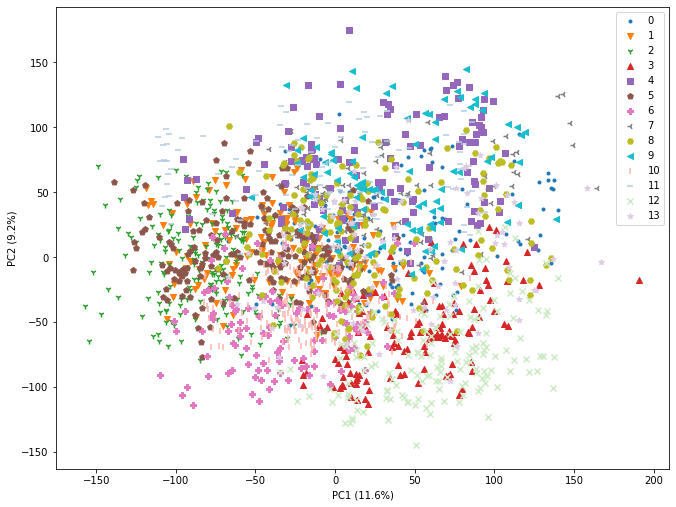


###### Scaled ######


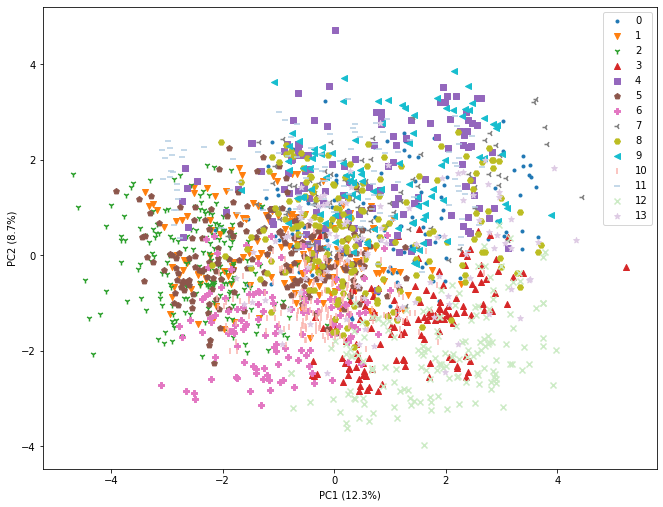


###### Cluster vs User ######


Cluster14,0,1,2,3,4,5,6,7,8,9,10,11,12,13
User,,,,,,,,,,,,,,
0,166,190,223,543,86,204,274,80,266,90,259,91,949,220
1,165,121,20,82,300,131,15,184,227,143,460,287,96,150
2,185,179,124,6,114,244,265,95,238,96,6,126,55,184
4,5,1,1,7,4,4,1,7,9,5,0,2,15,14
5,174,434,377,86,331,548,184,124,210,133,75,521,39,63
6,451,219,32,19,323,210,53,281,348,376,27,228,71,222
7,9,2,5,12,11,2,7,11,12,9,0,6,38,26
8,200,267,246,71,179,330,328,144,185,131,33,155,293,184
9,259,257,18,411,149,319,29,149,298,188,654,149,171,211


In [7]:
#your code here

print('\n###### Unscaled #####')
plot_clusters(posture_processed, 'Cluster14', False)
print('\n###### Scaled ######')
plot_clusters(posture_processed, 'Cluster14', True)

print('\n###### Cluster vs User ######')
display(pd.crosstab(postures.User, posture_processed.Cluster14))

# Analysis

***Key Observations:***
* Plots using scaled or unscaled data look very similar. Unscaled principal componets capture 20.8% of the variance whereas scaled principal components capture 21.0%, i.e. not much difference.
* Also to note that first 2 principal components only capture 21% of the variance.
* The clustering plots against 2-primary principal componets are very noisy and does not yeild desired outcome. This is not surprising as with only 21% of the variance capture, its unlikely to yeild desired seperation in 2-D plot.
* ***However, since we have happen to have label data in this case,*** it will be interesting to see how well clustering worked in comparison to the User labels. On making that comparison, we find that K-Means fails to yield the desired results. Clustering algorithm is not capturing user differentiation in the data set.
* **8 coordinate points across 5 different hand gestures are not enough to make an identification:**
    - Should we celebrate that inocous thing like hand gesture may not be enough to violate our privacy?
    - Can other algorithms solve this challenge or do we more features i.e. coordinates?

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q1b
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Great explanation. Good job discussing and paying attention to the axes in this plot and variance explained in those components. 
</span></div>
</div>

(c) Plot the silhouette scores using the function below, from lecture. Give it a 10% sample of the data to speed the visualization. How reasonable does the clustering seem based on this plot? How does it compare to the information in the plot above?

In [8]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
#modified code from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silplot(X, cluster_labels, clusterer, pointlabels=None):
    n_clusters = clusterer.n_clusters
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(11,8.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = ", n_clusters,
          ", the average silhouette_score is ", silhouette_avg,".",sep="")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(0,n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=200, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    xs = X[:, 0]
    ys = X[:, 1]
    
    if pointlabels is not None:
        for i in range(len(xs)):
            plt.text(xs[i],ys[i],pointlabels[i])

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % int(i), alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

For n_clusters = 14, the average silhouette_score is 0.06619083276250814.


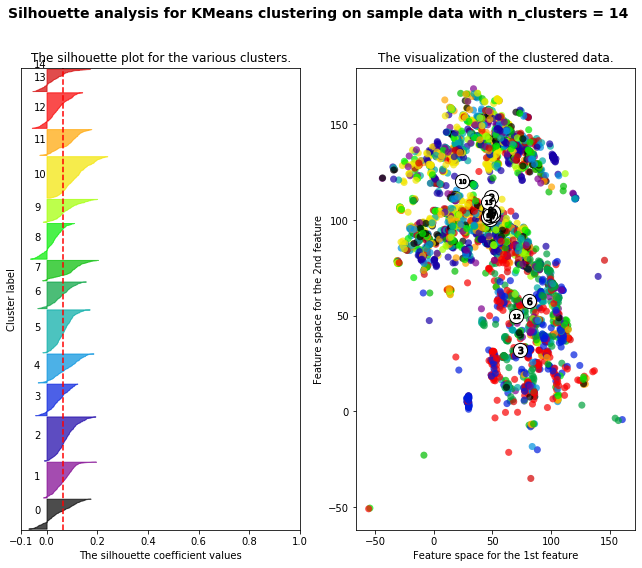

In [9]:
#your code here

X = posture_processed.sample(frac=0.1, random_state=109)
silplot(X.drop(['Cluster14'], axis = 1).to_numpy() , X.Cluster14.to_numpy(), 
        kmeans_user, pointlabels=None)

# Analysis

***Silhouette score plot reveals the following:***
* Low score overall and across the clusters point to a very noisy data and not enough information to seggregate the data points into 14 clusters.
* Further visualization of the data across the first 2-feature vector does not reveal any decipherable pattern, which is not surprising.
* Another observation is that around half the cluster centers are bunched up with each other in 2-feature vector plot.
* This analysis further enhances the conclusion drawn from the pervious plot that K-Means is not doing a good job of clustering.

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q1c
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>There was a bug in the silplot function we provided that made the function plot the first two features instead of the first two principal components. Because of this, your results might've seemed unintuitive and hard to visualize. No points deducted
</span></div>
</div>

(d) Repeat all of the above steps, but attempting to group by posture rather than by user. That is : 

(i) Run the k-means algorithm with 5 centroids instead of 14, creating a variable named `Cluster5` and adding it to the dataset. 

(ii) Visualize the results for k-means. Does 5 clusters seem to make sense from this plot?

(iii) Plot the silhouette scores on a 10% sample of the data. How reasonable does the clustering seem based on this plot?

,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,...,Y5,Z5,X6,Y6,Z6,X7,Y7,Z7,Cluster14,Cluster5
0,72.692270,50.023771,-72.963253,-11.593076,81.234142,-28.450210,51.729995,82.844469,-55.674024,86.175444,...,88.967979,-32.045120,7.732511,25.135415,10.723395,55.943868,19.513363,-70.380124,3,0
1,85.648015,73.561022,-71.838316,31.595034,90.217896,-47.246688,52.230858,82.361548,-55.975665,74.817984,...,88.607958,-32.037539,56.308829,18.774768,-70.996523,6.913199,24.967750,9.697553,3,2
2,-10.346977,81.751331,-25.587870,33.414886,91.985986,-41.364447,5.625100,24.523349,8.120352,52.961965,...,75.505188,-67.462052,56.807276,20.950953,-68.375831,11.602112,89.400536,-29.062279,9,1
3,63.554969,98.490988,11.165920,49.159831,154.330730,32.004168,92.793124,137.143202,1.064904,80.854870,...,27.499634,-71.713081,12.660462,95.077144,29.664434,84.110115,151.545456,16.891147,0,1
4,80.873812,93.722537,-4.988816,63.572103,98.476638,11.242908,49.142700,154.347050,32.076937,95.211973,...,132.913455,35.349247,92.942044,137.182817,1.297511,35.480104,99.739019,22.802243,8,4



###### Unscaled #####


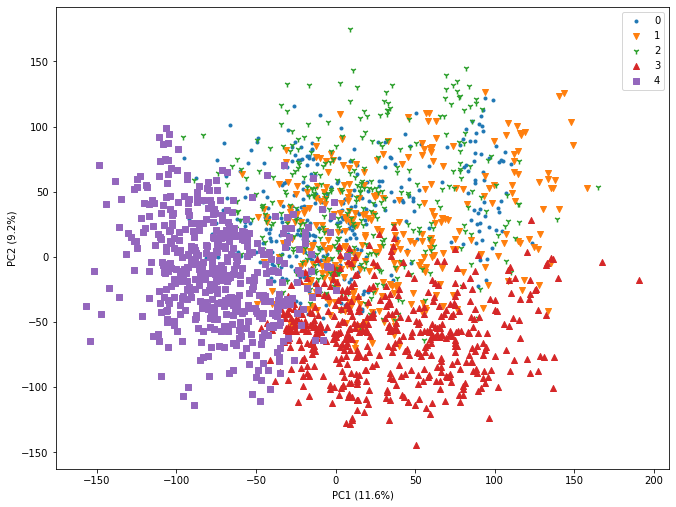


###### Scaled ######


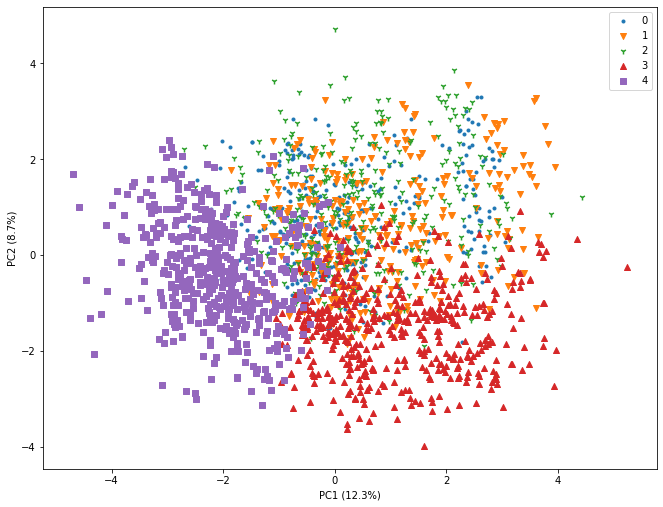


###### Cluster vs Class ######


Cluster5,0,1,2,3,4
Class,,,,,
1,4,3,5,3,37
2,2120,1663,1903,1331,7651
3,915,1117,989,460,75
4,1628,1437,1934,557,211
5,2266,2088,2166,7197,1183


In [10]:
#your code here

kmeans_class = KMeans(n_clusters=postures.Class.unique().shape[0], n_init=46, 
                      random_state=109, n_jobs=-1).fit(posture_processed)
posture_processed['Cluster5'] = kmeans_class.predict(posture_processed)
display(posture_processed.head())

print('\n###### Unscaled #####')
plot_clusters(posture_processed, 'Cluster5', False)
print('\n###### Scaled ######')
plot_clusters(posture_processed, 'Cluster5', True)

print('\n###### Cluster vs Class ######')
display(pd.crosstab(postures.Class, posture_processed.Cluster5))

# Analysis

***Key Observations:***
* Plots using scaled or unscaled data look very similar just like in case of K=14.
* The clustering plots against 2-primary principal componets are somewhat better than in case of 14 clusters. 2 clusters seem to stand out but other three are still very noisy and does not yield desired outcome. This is not surprising as with only 21% of the variance capture, its unlikely to yeild desired seperation in 2-D plot.
* ***Again since we have happen to have label data in this case,*** it will be interesting to see how well clustering worked in comparison to the Class labels. On making that comparison, we find that K-Means fails to yield the desired results. 
* ***Clustering algorithm is not capturing class differentiation in the data set except for Class 2 and 5 where around 50% of the data is labeled in Cluster 4 and 3 respectively.*** If data is clustered in Cluster 3 or 4, then it is likely that data came from class 5 or 2 respectively.

For n_clusters = 5, the average silhouette_score is 0.0699254848993262.


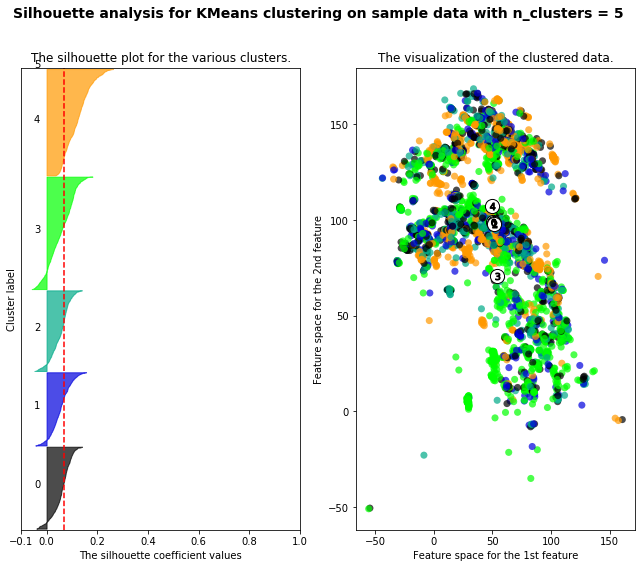

In [11]:
#your code here

X = posture_processed.sample(frac=0.1, random_state=109)
silplot(X.drop(['Cluster14', 'Cluster5'], axis = 1).to_numpy() , X.Cluster5.to_numpy(), 
        kmeans_class, pointlabels=None)

# Analysis

***Silhouette score plot reveals the following:***
* Low score overall and across the clusters point to a very noisy data and not enough information to seggregate the data points into 5 clusters.
* Further visualization of the data across the first 2 feature vector does not reveal any decipherable pattern, which is not surprising.
* Again similar to 14 cluster case, there is bunching of cluster centers in 2-feature vector plot.
* This analysis further enhances the conclusion drawn from the pervious plot that K-Means is not doing a good job of clustering.


<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q1d
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Great work! The same silplot number of features issue is present here, but no points off.
</span></div>
</div>

(e) What do the results suggest? Does this make sense in the context of what we know about the problem?

# Analysis

***14 Clusters:***
* K-Means does a poor job of cluster in this case for the given data and K=14
* K=14 clustering is equivalent of trying to cluster data according to the user based on the 8 hand sensor locations.
* In effect it becomes guessing the identity of the person based on the approximate hand size and position of the fingers. This will be extremely hard task, with just 8*3 position coordiates of the hand sensors, if not downright impossible. 

***5 Clusters:***
* K-Means does a poor job of cluster in this case for the given data and K=5
* K=5 clustering is equivalent of trying to cluster data according to the hand gesture based on the 8 hand sensor locations.
* If we look at the clustering results carefully in comparison to the actual lables, it looks like K-Means had some success in identifying Class 2 & 5, both of which had 14K+ training data points. It **maybe** possible to achieve better results than above, if we have similar numbers of data points for the other classes as well.

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q1e
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Great job tying the results of your analysis back into the context of the problem (i.e. 5 postures vs 14 users).
</span></div>
</div>

<div class='exercise'> <b> Problem 2: Other Ks  </b> </div>

In the previous problem, we examined the results of running k-means with 5 and 14 centroids on the postures data. In this problem, we will investigate a broader range of possible cluster sizes, with a borader range of metrics. 

**For all of these questions, you should work with a sample of 2,000 data points drawn with `pd.sample` and a random seed of 109.**

(a) Use the elbow method to evaluate the best choice of the number of clusters, plotting the total within-cluster variation against the number of clusters, for k-means clustering with $k \in \{1,2,...,15\}.$
 

In [12]:
#your code here

inertia = []
K = list(range(1,16))
sample_df = posture_processed.sample(2000, random_state=109).drop(['Cluster14', 'Cluster5'], axis=1)
for k in K:
    kmean = KMeans(n_clusters=k, n_init=46, random_state=109, n_jobs=-1).fit(sample_df)
    inertia.append(kmean.inertia_)
k_means = pd.DataFrame({'k': K, 'inertia': inertia})

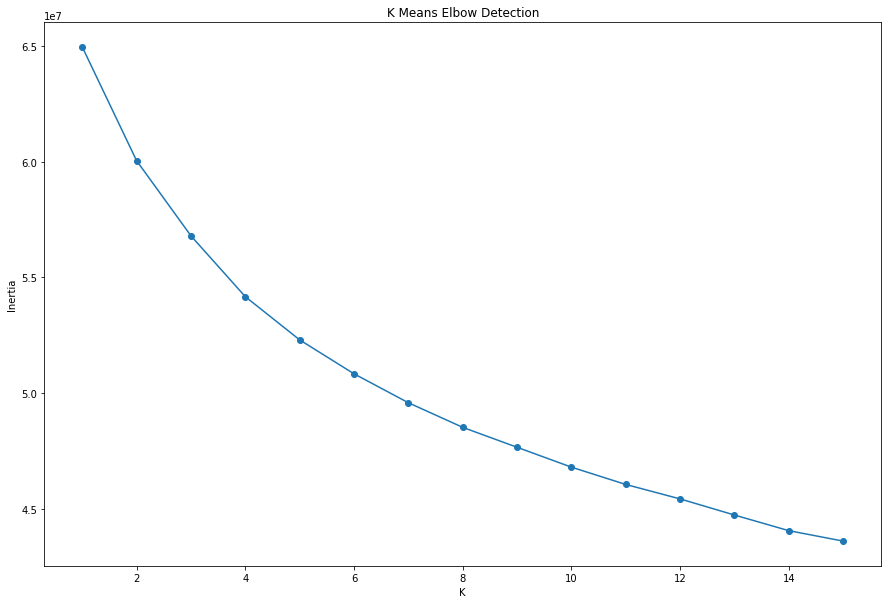

In [13]:
plt.figure(figsize=(15,10))
plt.plot(k_means.k, k_means.inertia, '-o')
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title('K Means Elbow Detection')
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


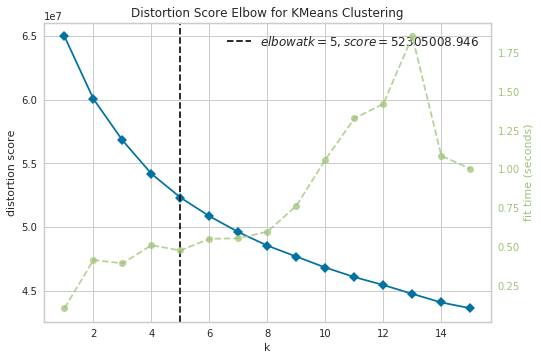

In [14]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(n_init=46, random_state=109, n_jobs=-1)
visualizer = KElbowVisualizer(model, k=(1,16))
visualizer.fit(sample_df)
visualizer.show()

# Analysis

***Elbow Analysis:***
* Inertia vs K graph is relatively smooth and it is hard to decipher the elbow point.
* One could easily pick between K = 4, 5, or 6.
* We use KElbowVisualizer from yellowbrick module to determine the value of K, which gives us K=5. Surprisingly this is also equal to the number of hand gestures/classes.

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q2a
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Good job.
</span></div>
</div>

(b) Use the average silhouette to evaluate the choice of the number of clusters for k-means clustering with $k \in \{1,2,...,15\}$. Plot the results. 

In [15]:
#your code here

X = sample_df
silhouette = [0]
K = list(range(1,16))
for k in range(2,16):
    kmean = KMeans(n_clusters=k, n_init=46, random_state=109, n_jobs=-1).fit(X)
    cluster_labels = kmean.predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette.append(silhouette_avg)
k_means_silh = pd.DataFrame({'k': K, 'silhouette score': silhouette})

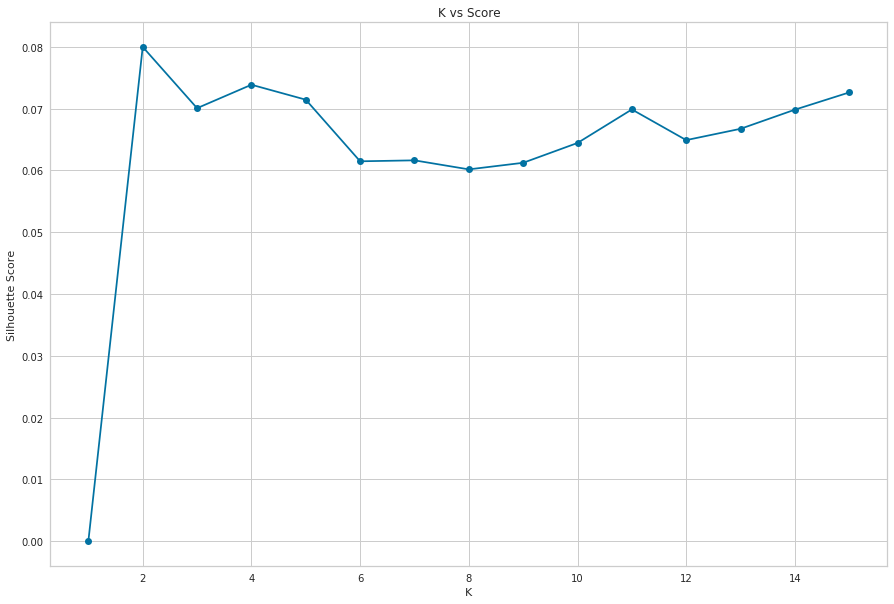

In [16]:
plt.figure(figsize=(15,10))
plt.plot(k_means_silh.k, k_means_silh['silhouette score'], '-o')
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title('K vs Score')
plt.show()

# Analysis

***Silhouette Score Chart***
* Silhouette Score varies between 0.06 and 0.08 i.e. K-Means clustering is very nosiy for this data and does not yield a good clustering
* K=2 and K=4 yields highest and second highest scores. It could be because when K=2 K-Means does good job of identifying Class 2 & 5 but presence of other classes add to the noise. And when K=4 as we saw earlier Cluster 3 & 4 equate with Class 5 and 2 and rest is a lot of noise; having more data across other classes may improve the score and performance.

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q2b
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Good work.
</span></div>
</div>

(c) Use the gap statistic to evaluate the choice of the number of clusters for k-means clustering with $k \in \{1,2,..,15\}$. Plot the results. 

Optimal clusters:  15


,n_clusters,gap_value,gap*,ref_dispersion_std,diff,diff*
0,1.0,-9.696425,-6.495012e+07,18.759359,-0.042711,5.589741e+07
1,2.0,-9.649497,-6.012463e+07,16.193579,-0.025564,5.455493e+07
2,3.0,-9.620586,-5.705591e+07,12.538870,-0.022836,5.266012e+07
3,4.0,-9.594244,-5.458644e+07,12.899533,-0.010578,5.167241e+07
4,5.0,-9.578919,-5.286640e+07,17.185197,-0.013562,5.015972e+07


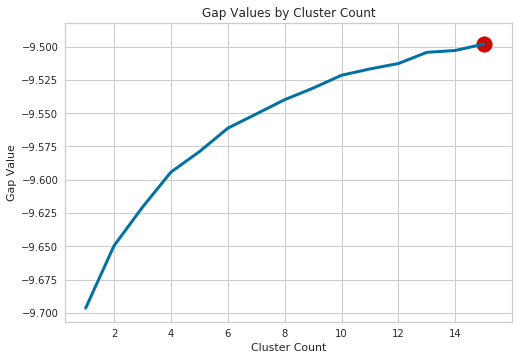

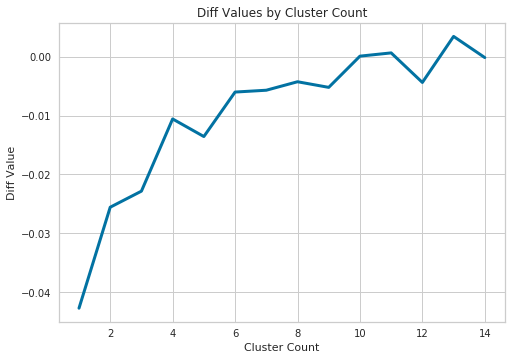

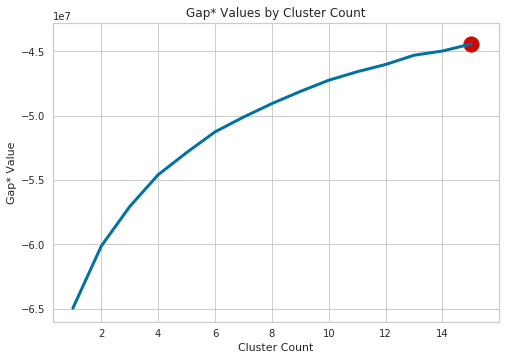

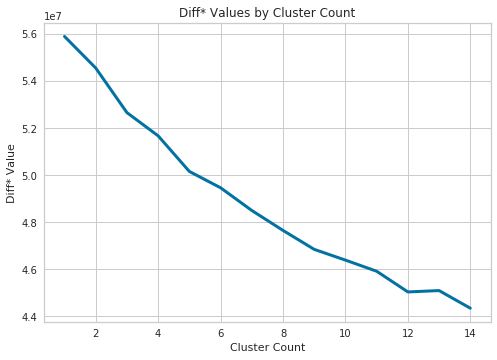

In [17]:
#your code here

gs_obj = OptimalK()
X = X.values
n_clusters = gs_obj(X, n_refs=50, cluster_array=np.arange(1, 16))
print('Optimal clusters: ', n_clusters)
display(gs_obj.gap_df.head())
gs_obj.plot_results()

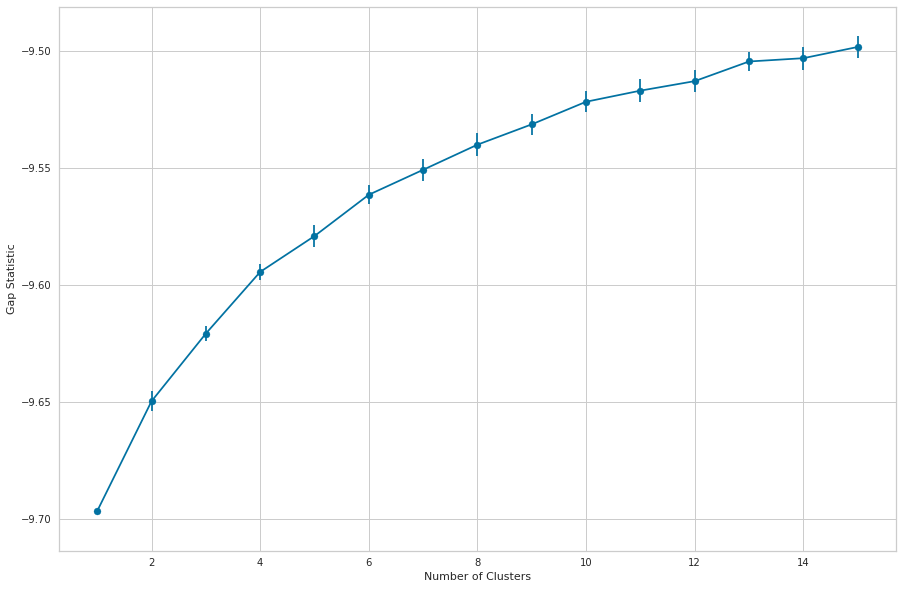

In [18]:
def display_gapstat_with_errbars(gap_df):
    gaps = gap_df["gap_value"].values
    diffs = gap_df["diff"]
    
    err_bars = np.zeros(len(gap_df))
    err_bars[1:] = diffs[:-1] - gaps[:-1] + gaps[1:]
    
    plt.figure(figsize=(15,10))
    plt.scatter(gap_df["n_clusters"], gap_df["gap_value"])
    plt.errorbar(gap_df["n_clusters"], gap_df["gap_value"], yerr=err_bars, capsize=6)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Gap Statistic")
    plt.show()

display_gapstat_with_errbars(gs_obj.gap_df)

# Analysis

***Gap Statistics Analysis:***
* Based on the standard Gap Statistics and taking into account error bars, the optimal value of K is 10. 
* Due to randomness involved in the computation, the error bars and the mean gap value may change slightly from iteration to iteration, leading another optimal value of K equal to 7, 8 or 9.

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q2c
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Good job.
</span></div>
</div>

(d) After analyzing the plots produced by all three of these measures, discuss the number of k-means clusters that you think is the best fit for this dataset. Defend your answer with evidence from the previous parts of this question, the three graphs produced here, and what you surmise about this dataset.

# Analysis

**We will look at this two ways while keeping in mind the following results:**

* ***Elbow Method:*** Optimal K = 5
* ***Silhouette Score:*** Optimal K = 2 (4 is the next best)
* ***Gap Statistics:*** Optimal K = 10

***Without considering label information:***
* All three methods give diverging information.
* ***Will pick K = 5 as the optimal value of K.***
    - 5 (Elbow method) is between 2 (Silhouette Score) & 10 (Gap Statistic)
    - Second best value as per Silhouette Score is K = 4 which is also close to 5
    - For K = 5, cluster plot is able to seperate 2 clusters from the rest with resonable boundary, which maybe of economic value

***Considering label information:***
* It is unlikely that we can predict user identity i.e. K = 14 using this data and K-Means
* K = 10 is not giving meaningful information in this given context
* K = 5, will rule-out as we know that data meaningfully only represents 4 classes
* The choice is to either use K = 2 as suggested by Silhouette Score or K = 4 which is the next best alternative and also represents practical number of training classes.
* Further-more for K=4, if the prediction is cluster 3 or 4, we can assign them to the correct class with resonable surety which is of some value.
* ***Based on the above, will pick K = 4 as the optimal value of K***

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q2d
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Great job! Very thorough.
</span></div>
</div>

<div class='exercise'> <b> Problem 3: Alternative Algorithms  </b> </div>

(e) Run DBSCAN on the data. How many clusters are found, and how well does this clustering perform on e.g. silhouette score, excluding the points not assigned to any cluster?  
*Note*: Do not use a sample of the data. Running the algorithm may take up to 5-10 minutes.

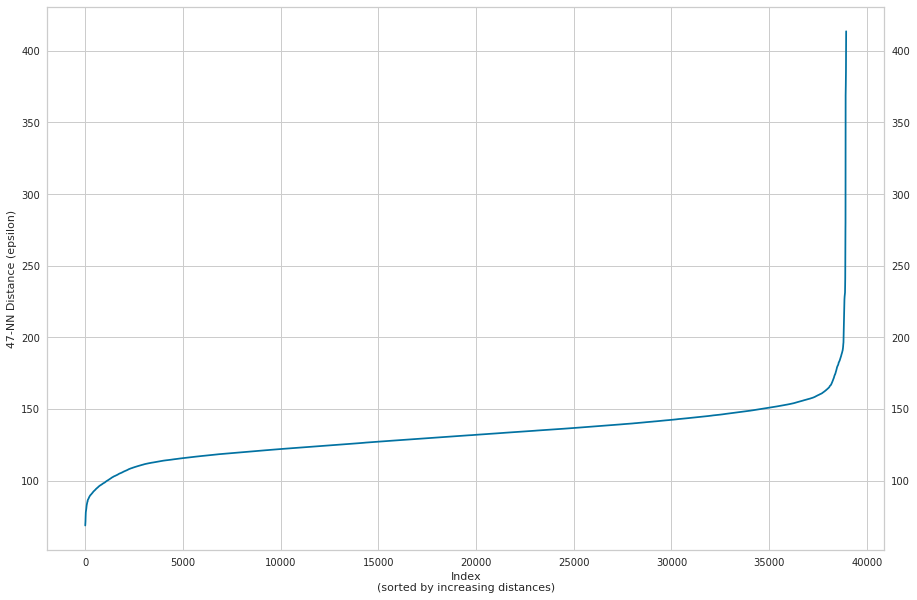

In [19]:
#your code here
from sklearn.neighbors import NearestNeighbors

def plot_epsilon(df, min_samples):

    fitted_neigbors = NearestNeighbors(n_neighbors=min_samples, n_jobs=-1).fit(df)
    distances, indices = fitted_neigbors.kneighbors(df)
    
    dist_to_nth_nearest_neighbor = distances[:,-1]
    plt.figure(figsize=(15,10))
    plt.plot(np.sort(dist_to_nth_nearest_neighbor))
    plt.xlabel("Index\n(sorted by increasing distances)")
    plt.ylabel("{}-NN Distance (epsilon)".format(min_samples-1))
    plt.tick_params(right=True, labelright=True)
    plt.show()

X = posture_processed.drop(['Cluster14', 'Cluster5'], axis=1).values
plot_epsilon(X, X.shape[1]*2)

# Analysis

***Value of Epsilon:***
* We use elbow method to determine value of epsilon
* MinPoints are take as the twice the number of features i.e. 2*24 = 48
* From the plot we see that optimal epsilon should be somewhere around 165
* There is another elbow point around 90 but that covers very small portion of data and hence we choose 165.
* ***I would also like to add that I also tried the above exercise for minPoints = 25 nd 36 and got very similar results for the optimal epsilon.***

In [20]:
dbscan = DBSCAN(eps=165, min_samples=X.shape[1]*2, n_jobs=-1).fit(X)

In [21]:
print('\n###### Clusters #####')
print(np.unique(dbscan.labels_))
print('\n###### No of Clusters #####')
print(dbscan.labels_.max()+1)
print('\n###### Score #####')
print('Silhouette Score = {}'.format(0 if dbscan.labels_.max()==0 else silhouette_score(X[dbscan.labels_>=0,], 
                                                                                   dbscan.labels_[dbscan.labels_>=0]
                                                                                  )))


###### Clusters #####
[-1  0]

###### No of Clusters #####
1

###### Score #####
Silhouette Score = 0


# Analysis

***DB Scan with epsilon = 165 & minPoints = 48:***
* DBScan with above parameters fails to cluser the data.
* Apart from the few points that are determined noisy, rest of data is clustered in a single cluster.
* Silhouette Score requires minimum of 2 clusters and hence its is set to Zero.
* ***I would also like to add my results were similar for minPoints = 25 and 36 as well.*** I do further exploration below.

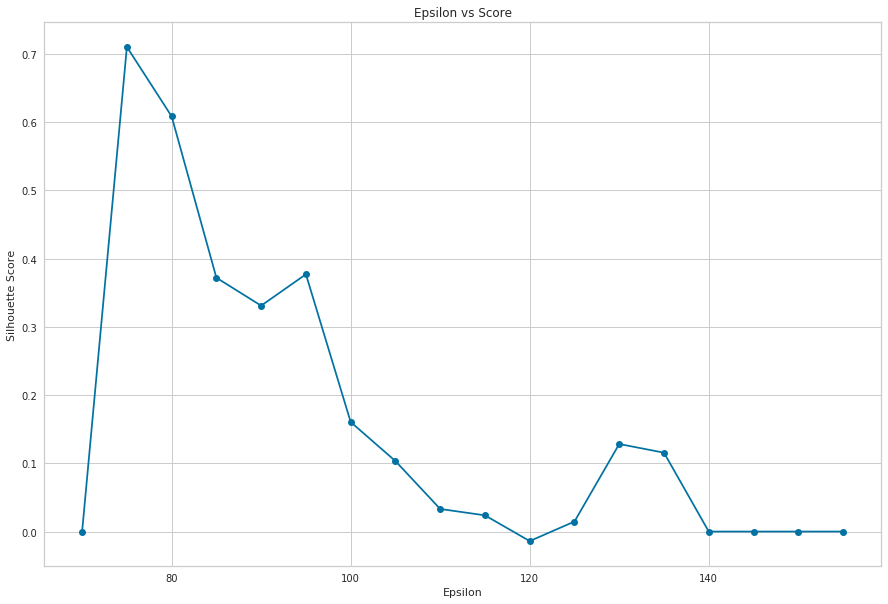

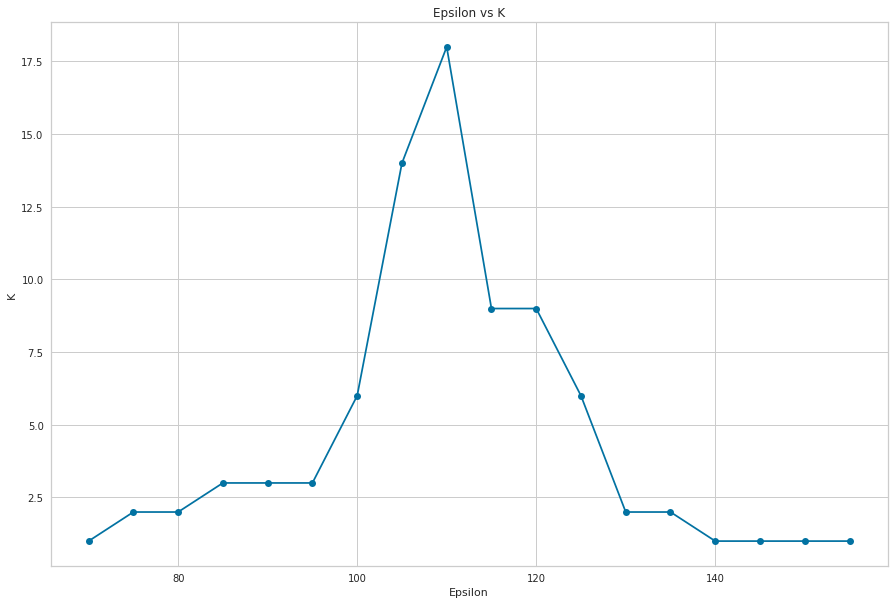

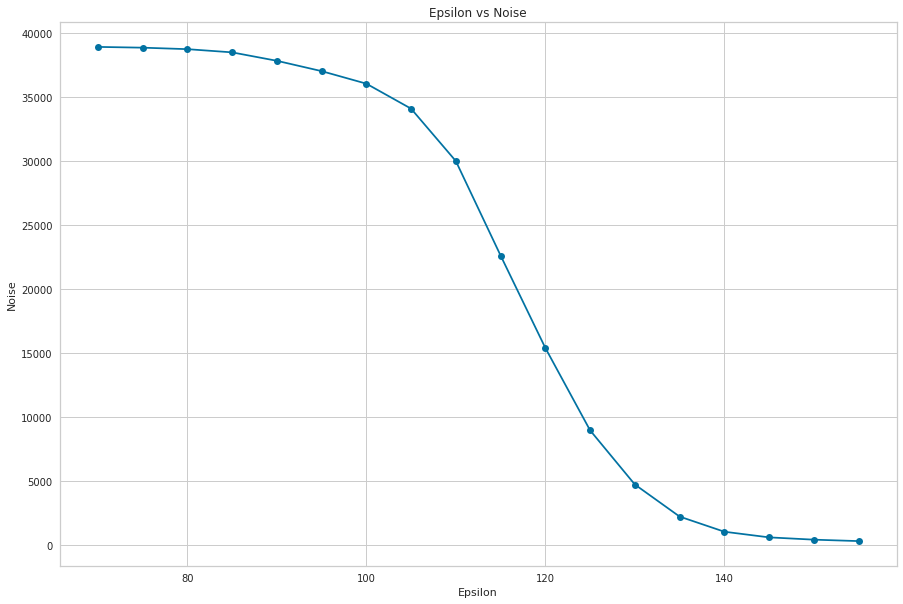

In [22]:
silhouette = []
K = []
noise = []
labels = []
E = list(range(70,160,5))
for e in E:
    dbscan = DBSCAN(eps=e, min_samples=X.shape[1]*2, n_jobs=-1).fit(X)
    silhouette_avg = 0 if dbscan.labels_.max()==0 else silhouette_score(X[dbscan.labels_>=0,], 
                                                                   dbscan.labels_[dbscan.labels_>=0])
    silhouette.append(silhouette_avg)
    K.append(dbscan.labels_.max()+1)
    noise.append(np.sum(dbscan.labels_==-1))
    labels.append(dbscan.labels_)
dbscan_silh = pd.DataFrame({'e': E, 'k': K, 'silhouette score': silhouette, 'noise': noise})

plt.figure(figsize=(15,10))
plt.plot(dbscan_silh.e, dbscan_silh['silhouette score'], '-o')
plt.xlabel("Epsilon")
plt.ylabel("Silhouette Score")
plt.title('Epsilon vs Score')
plt.show()

plt.figure(figsize=(15,10))
plt.plot(dbscan_silh.e, dbscan_silh.k, '-o')
plt.xlabel("Epsilon")
plt.ylabel("K")
plt.title('Epsilon vs K')
plt.show()

plt.figure(figsize=(15,10))
plt.plot(dbscan_silh.e, dbscan_silh.noise, '-o')
plt.xlabel("Epsilon")
plt.ylabel('Noise')
plt.title('Epsilon vs Noise')
plt.show()

In [23]:
display(dbscan_silh)

,e,k,silhouette score,noise
0,70,1,0.000000,38893
1,75,2,0.710334,38834
2,80,2,0.608535,38718
3,85,3,0.372011,38468
4,90,3,0.331059,37810
5,95,3,0.377068,37003
6,100,6,0.160534,36024
7,105,14,0.103304,34072
8,110,18,0.033089,29982
9,115,9,0.023761,22605


# Analysis

***Silhouette Score for DBScan:***
* We compute silhouette score for various values of epsilon ranging from 70 to 165.
* We plot the following:
    - Epsilon vs Score
    - Epsilon vs K i.e. number of clusters
    - Epsilon vs Noise i.e. number of data points classified as noise
* We see a very high value of silhouette score i.e. 0.71 for epsilon = 75 and K = 2. However, it treats more than 99% of the data as noisy and fails to cluster them.
* For epsilon values of 130 and higher more than 85% are clustered and less than 15% are treated as noise. However the best silhouette score is 0.12 for epsilon = 130 and K = 2.
* DBScan is not doing a satisfactory job of clustering the data.

In [24]:
idx = [1, 5, 12]

for i in idx:
    print('\n###### Cluster vs Class for epsilon = {}, K = {}, & Silhouette Score = {} ######'.format(E[i],
                                                                                                      K[i],
                                                                                                      silhouette[i],))
    display(pd.crosstab(postures.Class, labels[i]))


###### Cluster vs Class for epsilon = 75, K = 2, & Silhouette Score = 0.7103336469082151 ######


col_0,-1,0,1
Class,,,
1,52,0,0
2,14617,0,51
3,3556,0,0
4,5767,0,0
5,14842,58,0



###### Cluster vs Class for epsilon = 95, K = 3, & Silhouette Score = 0.37706778521833983 ######


col_0,-1,0,1,2
Class,,,,
1,48,4,0,0
2,13157,1511,0,0
3,3556,0,0,0
4,5765,2,0,0
5,14477,0,352,71



###### Cluster vs Class for epsilon = 130, K = 2, & Silhouette Score = 0.128304219783988 ######


col_0,-1,0,1
Class,,,
1,4,48,0
2,669,13999,0
3,396,3160,0
4,679,5088,0
5,2975,11834,91


# Analysis

***Comparison against Class labels:***
* Since we have the labels available for this data set we try and compare clustering results against the Class labels.
* We narrow our choices to epsilon values of 75, 95, & 130 since these are the global/local optimum points for the silhouette score
* While we do get some interesting information for epsilon of 75 and 95 but that relies on a very small subset of data and may not be useful for analysis/prediction due to robustness issues.

In [25]:
idx = [7, 8]

for i in idx:
    print('\n###### Cluster vs User for epsilon = {}, K = {}, & Silhouette Score = {} ######'.format(E[i],
                                                                                                      K[i],
                                                                                                      silhouette[i],))
    display(pd.crosstab(postures.User, labels[i]))


###### Cluster vs User for epsilon = 105, K = 14, & Silhouette Score = 0.10330409181887766 ######


col_0,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13
User,,,,,,,,,,,,,,,
0,3609,23,0,2,0,0,0,0,0,3,1,0,0,2,1
1,2274,56,0,47,0,0,0,0,0,0,1,3,0,0,0
2,1874,42,0,0,0,0,0,0,0,0,0,0,0,0,1
4,75,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2266,1001,32,0,0,0,0,0,0,0,0,0,0,0,0
6,2773,8,4,0,9,2,13,14,0,0,25,12,0,0,0
7,150,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2654,55,0,1,11,1,14,6,0,0,3,0,0,0,1
9,2965,17,0,259,5,5,6,5,0,0,0,0,0,0,0



###### Cluster vs User for epsilon = 110, K = 18, & Silhouette Score = 0.033089279261777745 ######


col_0,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
User,,,,,,,,,,,,,,,,,,,
0,3515,122,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0
1,2036,321,0,0,5,0,6,4,1,0,0,0,1,0,0,0,3,4,0
2,1770,126,1,7,0,0,3,7,1,0,0,0,1,0,0,0,0,0,1
4,75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2017,1122,34,21,31,34,21,8,0,0,0,0,0,0,0,0,0,0,11
6,2606,26,20,8,2,0,57,35,35,0,4,5,13,6,0,0,26,16,1
7,148,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,2473,198,0,3,0,0,27,13,3,0,10,8,6,4,0,0,1,0,0
9,2581,615,3,4,0,0,10,12,0,0,11,10,10,6,0,0,0,0,0


# Analysis

***Comparison against User labels:***
* We also try and compare clustering results against the User labels.
* We narrow our choices to epsilon values of 7105 and 110 since for these number of cluster is higher i.e. 14 and 18 respectively.
* While we can try and force squeze some analysis out of the above, but in our opinion clustering does not signal any real coorelation with the user label.

# Analysis

***Overall analysis of DBScan:***
* Based on the extensive analysis above, DBScan doesn't do a good job of clustering this dataset.

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q3a
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Great job, very thorough.
</span></div>
</div>

(f) Hierarchical clustering. Run agglomerative clustering (using Ward's method), and plot the result using a dendrogram. Interpret the results, and describe the cluster size(s) the plot suggests. What level of aggregation is suggested by the sihoutte score?

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


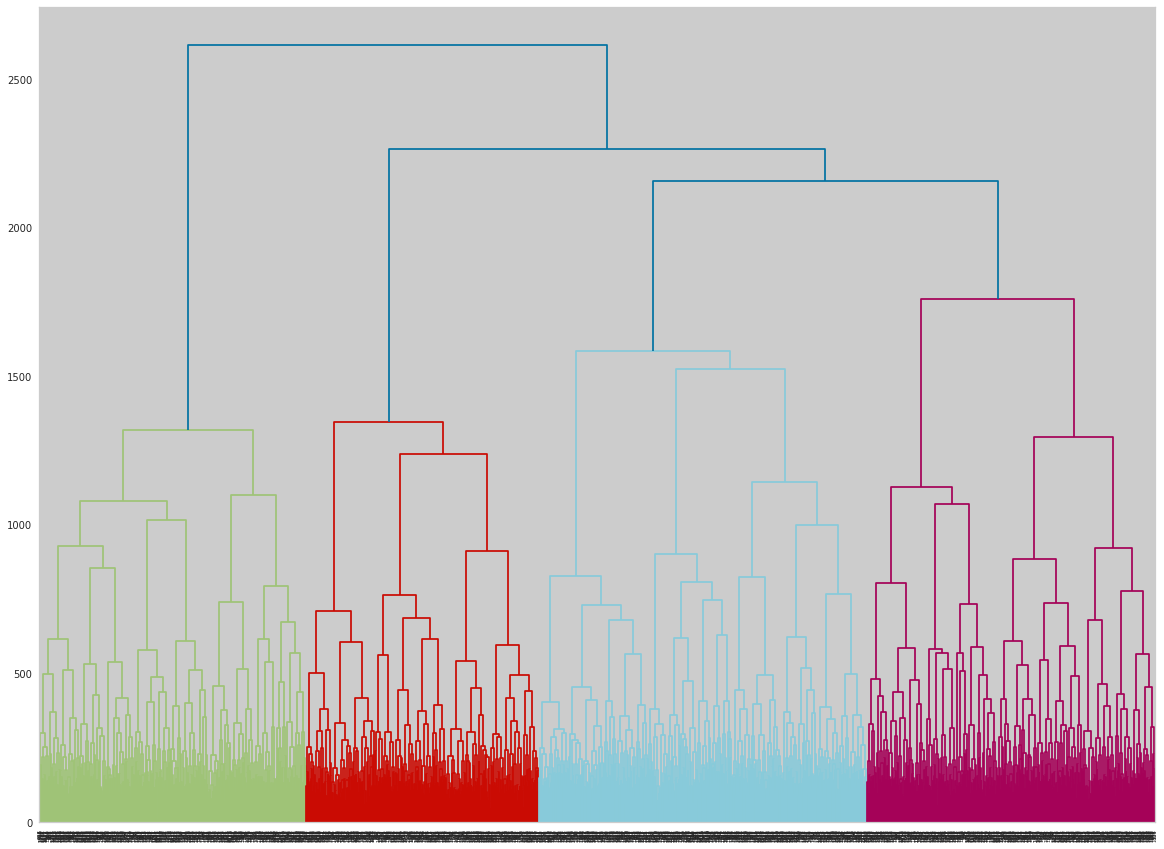

In [26]:
#your code here

from scipy.cluster.hierarchy import fcluster

X = posture_processed.sample(2000, random_state=109).drop(['Cluster14', 'Cluster5'], axis=1)
y = postures.iloc[X.index]['Class']
z = postures.iloc[X.index]['User']
dist_mat = pdist(X, metric="euclidean")
ward_data = hac.ward(dist_mat)
plt.figure(figsize=(20,15))
hac.dendrogram(ward_data);

# Analysis

***Dendrogram Plot Analysis:***
* From dedrogram we can determine optimal number of clusters = 4.
* Clusters are of unequal sizes with second cluster being the samllest with 416 elements and third cluster being the largest with 588 elements
* The reasoning behind the choice of 4 is that visual inspection reveals 4 natural set of clusters marked by dark blue lines i.e. taking t = 2000 for height of dendrogram as a cut-offs point for clustering. If for example cutoff height is set to 2200, we would have choosen K = 3.

In [27]:
print('\n###### Cluster vs Class (K=4) ######')
display(pd.crosstab(y, fcluster(ward_data, 4, criterion='maxclust')))


###### Cluster vs Class (K=4) ######


col_0,1,2,3,4
Class,,,,
1,0,1,0,1
2,153,315,126,161
3,66,7,30,91
4,106,8,37,119
5,153,86,395,145


# Analysis

***Comparison against class labels:***
* Analysing against the class label, we see that clustering to a small extent is able to seperate Class 2 and 5.
* Other than that not much information related to classes can be extracted with any measure of confidence.

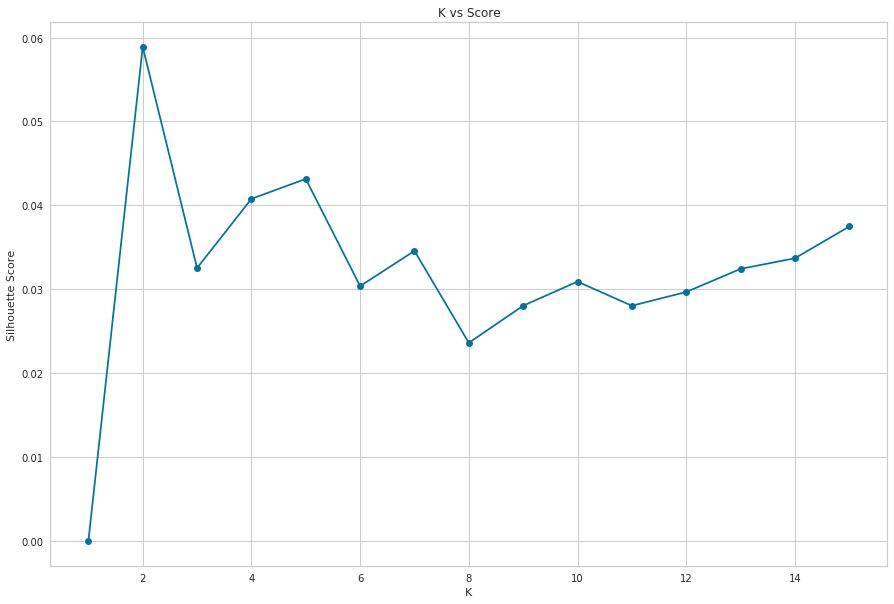

In [28]:
#your code here

silhouette = [0]
K = list(range(1,16))
for k in range(2,16):
    silhouette_avg = silhouette_score(X.values, fcluster(ward_data, k, criterion='maxclust'))
    silhouette.append(silhouette_avg)
ward_silh = pd.DataFrame({'k': K, 'silhouette score': silhouette})

plt.figure(figsize=(15,10))
plt.plot(ward_silh.k, ward_silh['silhouette score'], '-o')
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title('K vs Score')
plt.show()

# Analysis

***Analysis of Silhouette Score:***
* K = 2 again comes as the optimal choice for number of clusters; abslute score however is very low.
* K = 5 is the next best choice.
* Shape of this plot is somewhat similar to the Silhouette plot for K-Means
* Another point to note is that for all three methods i.e. K-Means, DBScan and Ward's, Silhouette score has suggested optimal K = 2.

In [29]:
print('\n###### Cluster vs Class (K=2) ######')
display(pd.crosstab(y, fcluster(ward_data, 2, criterion='maxclust')))

print('\n###### Cluster vs Class (K=5) ######')
display(pd.crosstab(y, fcluster(ward_data, 5, criterion='maxclust')))


###### Cluster vs Class (K=2) ######


col_0,1,2
Class,,
1,0,2
2,153,602
3,66,128
4,106,164
5,153,626



###### Cluster vs Class (K=5) ######


col_0,1,2,3,4,5
Class,,,,,
1,0,1,0,0,1
2,153,315,126,59,102
3,66,7,30,55,36
4,106,8,37,68,51
5,153,86,395,53,92


# Analysis

***Comparison against class labels:***
* Analysing against the class label, we see that clustering to a small extent is able to seperate Class 2 and 5 for K=5 similar to K=4

In [30]:
print('\n###### Cluster vs User (K=14) ######')
display(pd.crosstab(z, fcluster(ward_data, 14, criterion='maxclust')))


###### Cluster vs User (K=14) ######


col_0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
User,,,,,,,,,,,,,,
0,11,5,3,4,6,6,18,58,6,28,4,8,16,13
1,17,7,25,2,12,1,11,4,1,5,7,10,7,6
2,15,2,3,8,14,2,1,1,18,13,9,6,16,5
4,0,0,0,0,0,0,0,0,0,0,0,2,0,0
5,19,22,1,23,6,18,5,0,4,8,11,5,15,13
6,47,1,13,7,8,2,5,0,1,7,19,9,11,24
7,0,0,0,0,0,0,0,1,0,1,0,2,0,0
8,23,7,6,13,4,8,5,7,11,18,8,9,10,14
9,25,6,8,5,11,0,33,7,6,13,7,14,17,8


# Analysis

***Comparison against user labels:***
* Analysing against the user label, we see that ward's cluestring is not grouping the data as per users.

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q3b
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Great job! Make sure you remove the black blob on the xlabels in the dendrogram, it's just a bunch of overlapping text and doesn't look great (no points off).
</span></div>
</div>

(g) Overall, what do you conclude about the number and kind of clusters in this data set?

# Analysis

***Number and kind of clusters in the data:***
* First of all in my opinion, data cannot be clustered to reflect identity of the user.
* Clustering to relfect class i.e. hand gesture is also not showing much promise. 
* **Using K = 4 does seem to yield some segregation between class 2, 5, and rest of the classes but I will question if that relationship will hold in case of non-training data.** 
* There might be scope for improvement if more data is captured for other classes as well. Currently there is asymmetry between the amount of training data used for class 2 & 5 (14K+ each) versus less than 11K combined for classes 1,3 & 4. Class 1 is only 52 data points.
* **One interesting observation is that Silhouette Score is highest for K = 2 for all three methods (K-Means, DBScan, Ward's).** For DBScan with epsilon=75, score goes as high as 0.71
* **This might be because K=2 clustering using DBScan is able to find a natural cluster (other than class or user). For example, data might have been clustered based on hand size (big vs small) or hand length (long vs short) or width (wide vs slim).**
* Based on the above analysis, I prefer either K = 4 or K = 2; ***My strong preference is for K = 2 along with DBScan and epsilon = 75.** 
* **I would ideally like to do further analysis of the data to determine what do these cluster mean.**

<div class='alert alert-block' style='border-color:rgb(201, 201, 201); border-style:dashed; border-width: 3px'><div class='alert alert-block alert-primary'><b>Question : </b><span style = 'color:black'>Q3c
</span></div>
<div class='alert alert-block alert-info'><b>Comments : </b><span style = 'color:black'>Very good. The important point here is that different methods give different numbers of clusters with this dataset. Great job.
</span></div>
</div>

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Graded by: Alex Spiride
</footer>